## Time series forecasting for airport temperature data

The goal of this notebook is to demonstrate the use of machine learning to forecast temperatures given a time series input

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn import base
from sklearn.pipeline import FeatureUnion
from sklearn.metrics import r2_score
from collections import defaultdict
import seaborn as sns
sns.set()

In [2]:
import os
os.getcwd()

'/Users/arikaplan/Documents/job prep/showable-notebooks'

In [3]:
%matplotlib notebook

In [5]:
df = pd.read_csv('data/temperature_data.csv.gz', parse_dates=['time'])
df.head()

,station,time,temp,dew_point,pressure,wind_speed,wind_direction,precip_hour,weather_codes
0,PHX,2010-01-01 00:51:00,62.06,15.98,1024.90,3.00,20.00,M,M
1,PHX,2010-01-01 01:51:00,60.08,17.96,1025.30,4.00,50.00,M,M
2,PHX,2010-01-01 02:51:00,59.00,17.96,1025.60,4.00,30.00,M,M
3,PHX,2010-01-01 03:51:00,53.96,21.92,1026.00,0.00,0.00,M,M
4,PHX,2010-01-01 04:51:00,55.94,17.06,1026.20,5.00,40.00,M,M


In [6]:
#mask missing data
df = df[df['temp'] != 'M']

In [7]:
#simulate an incoming data set that is not in order
shuffled_df = df.sample(frac=1).reset_index(drop=True)

In [8]:
#split data into training and validation data
train_data = shuffled_df.loc[:int(len(shuffled_df)*0.8)]
valid_data = shuffled_df.loc[int(len(shuffled_df)*0.8):]

In [9]:
class IndexSelector(base.BaseEstimator, base.TransformerMixin):
    """Return indices of a data frame or Series for use in other estimators."""
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        return X.index

simple one hot encoding for hour of day and month of year, this model assumes temperature variation is only dependent on these two variables

In [10]:
class HourofDay(base.BaseEstimator, base.TransformerMixin):
    
    def fit(self, X, y=None):
        return self
    
    def hour_vector(self, hour):
        v = np.zeros(24)
        v[hour] = 1
        return v
    
    def transform(self, X):
        return np.stack([self.hour_vector(h) for h in X.hour]) 
    
class MonthofYear(base.BaseEstimator, base.TransformerMixin):
    
    def fit(self, X, y=None):
        return self
    
    def month_vector(self, month):
        v = np.zeros(12)
        v[month-1] = 1
        return v
    
    def transform(self, X):
        return np.stack([self.month_vector(m) for m in X.month]) 

In [11]:
union = FeatureUnion([('day', HourofDay()),
                      ('month', MonthofYear())])

In [12]:
def season_factory():
    return Pipeline([('indices', IndexSelector()),
                                ('union', union),
                                ('regressor', LinearRegression())])

In [13]:
class GroupbyEstimator(base.BaseEstimator, base.RegressorMixin):
    
    def __init__(self, column, estimator_factory):
        self.column = column # column is the value to group by
        self.estimator_factory = estimator_factory #estimator_factory can be called to produce estimators
        self.stations = list()
        self.station_dict = dict()
    
    def fit(self, X, y):
        #save index to a column for later grouping
        X['index'] = X.index
        X_sorted = X.sort_values([self.column,'time'],ascending=True).set_index('time') #index needs to be set to time
                                                                                        #for one hot encoding
        self.stations = X[self.column].unique()
        
        for city in self.stations: 
            X_station = X_sorted[X_sorted[self.column] == city]
            y_station = y[X_station['index'].values].astype(float) 
            
            self.station_dict[city] = self.estimator_factory()
            self.station_dict[city].fit(X_station,y_station)
                 
        return self

    def predict(self, X, flatten = False):
        X = X.set_index('time')
        station_predictions = dict()
        
        for city in self.stations:
            station_predictions[city] = self.station_dict[city].predict(X[X[self.column] == city])
            
        else:
            return station_predictions

In [14]:
season_model = GroupbyEstimator('station', season_factory).fit(train_data, train_data['temp'])

/var/folders/n8/mc27w99j19q1kx20z133q0w40000gp/T/ipykernel_42422/2223388292.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['index'] = X.index


In [15]:
ordered_valid = valid_data.sort_values(['station','time'],ascending=True)
predictions = season_model.predict(ordered_valid)

In [16]:
valid_data['station'].unique()

array(['SFO', 'PHNL', 'MSP', 'PHX', 'NYC'], dtype=object)

<IPython.core.display.Javascript object>


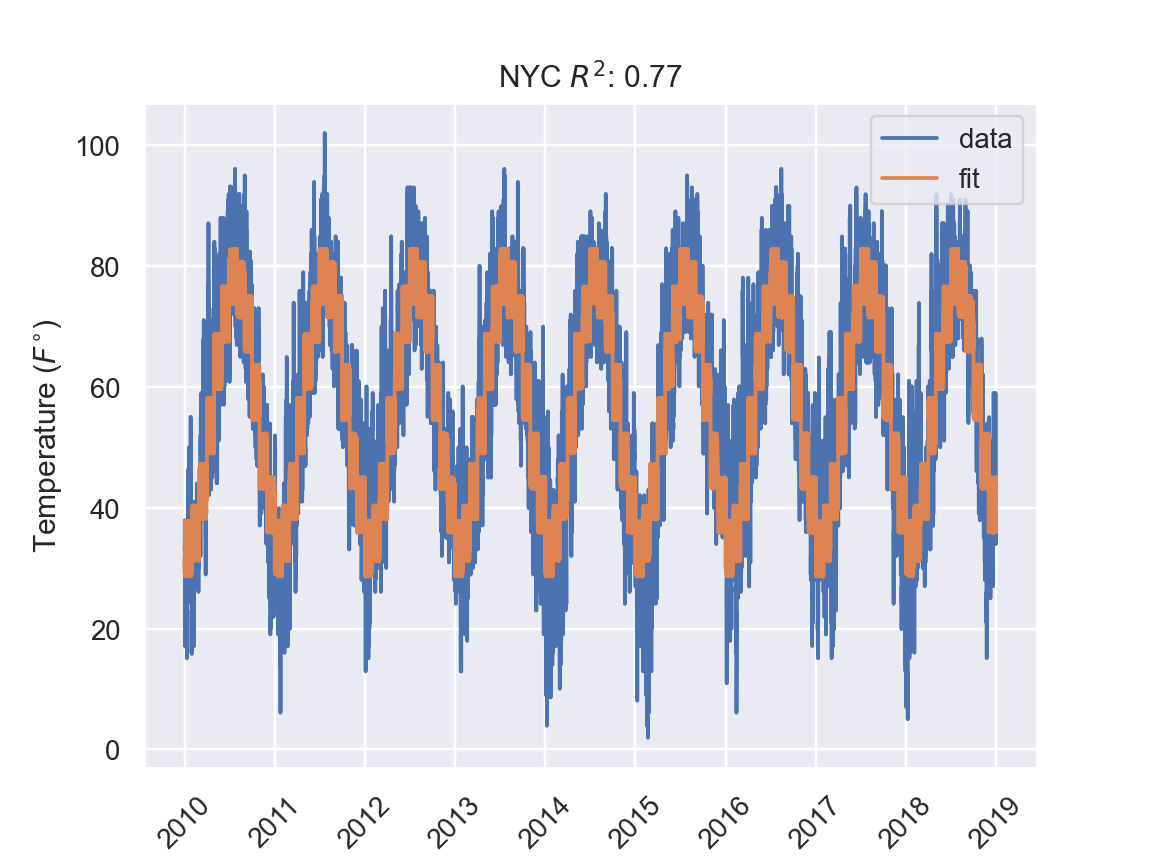

In [17]:
k = 'NYC'
ordered_valid = valid_data.sort_values(['station','time'],ascending=True).set_index('time')
y = ordered_valid[ordered_valid['station'] == k]['temp'].astype(float)
X = ordered_valid[ordered_valid['station'] == k].index

plt.figure()
plt.plot(X, y, label = 'data') 
plt.plot(X, predictions[k], label = 'fit')
plt.xticks(rotation=45);
plt.ylabel('Temperature ($F^{\circ}$)')

corr_matrix = np.corrcoef(ordered_valid[ordered_valid['station'] == k]['temp'].astype(float).values, predictions[k])
corr = corr_matrix[0,1]
R_sq = corr**2

plt.title('%s $R^2$: %.2f' % (k, R_sq))
plt.legend(loc='upper right')

<IPython.core.display.Javascript object>


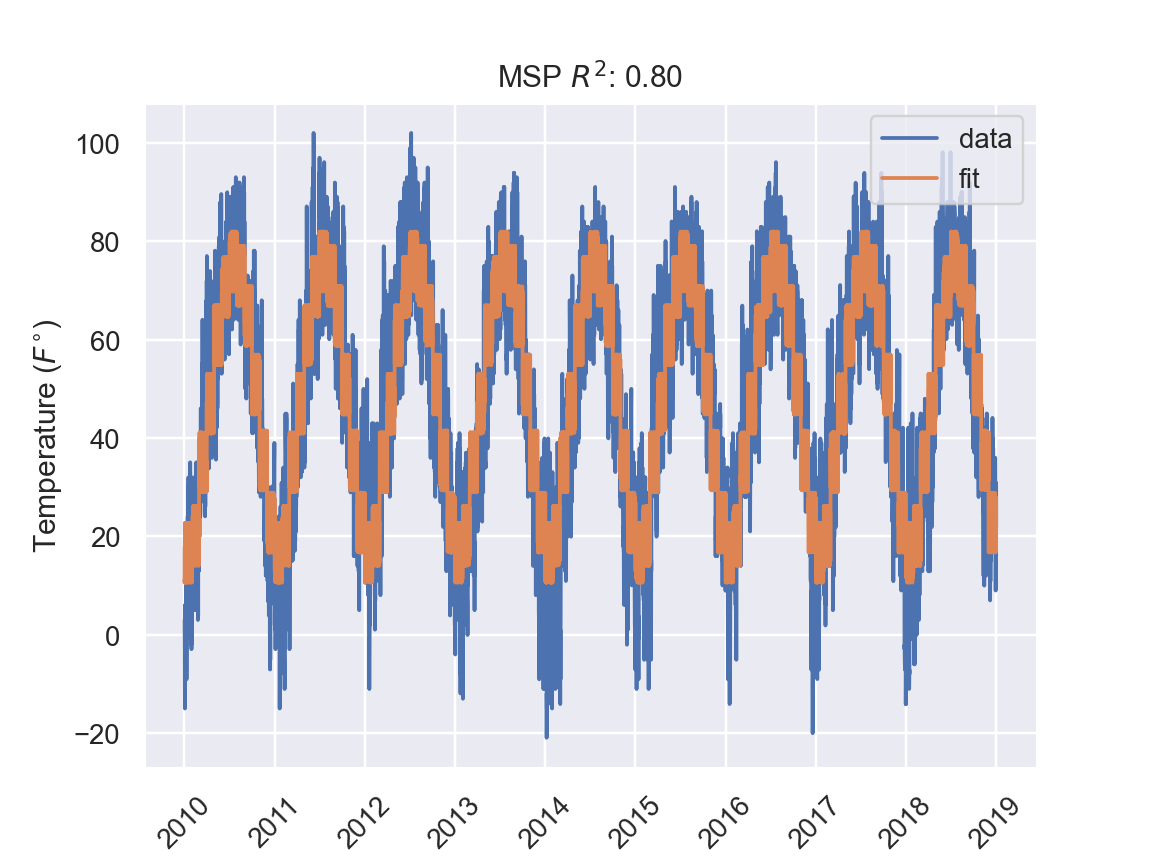

In [18]:
k = 'MSP'
ordered_valid = valid_data.sort_values(['station','time'],ascending=True).set_index('time')
y = ordered_valid[ordered_valid['station'] == k]['temp'].astype(float)
X = ordered_valid[ordered_valid['station'] == k].index

plt.figure()
plt.plot(X, y, label = 'data') 
plt.plot(X, predictions[k], label = 'fit')
plt.xticks(rotation=45);
plt.ylabel('Temperature ($F^{\circ}$)')

corr_matrix = np.corrcoef(ordered_valid[ordered_valid['station'] == k]['temp'].astype(float).values, predictions[k])
corr = corr_matrix[0,1]
R_sq = corr**2

plt.title('%s $R^2$: %.2f' % (k, R_sq))
plt.legend(loc='upper right')

<IPython.core.display.Javascript object>


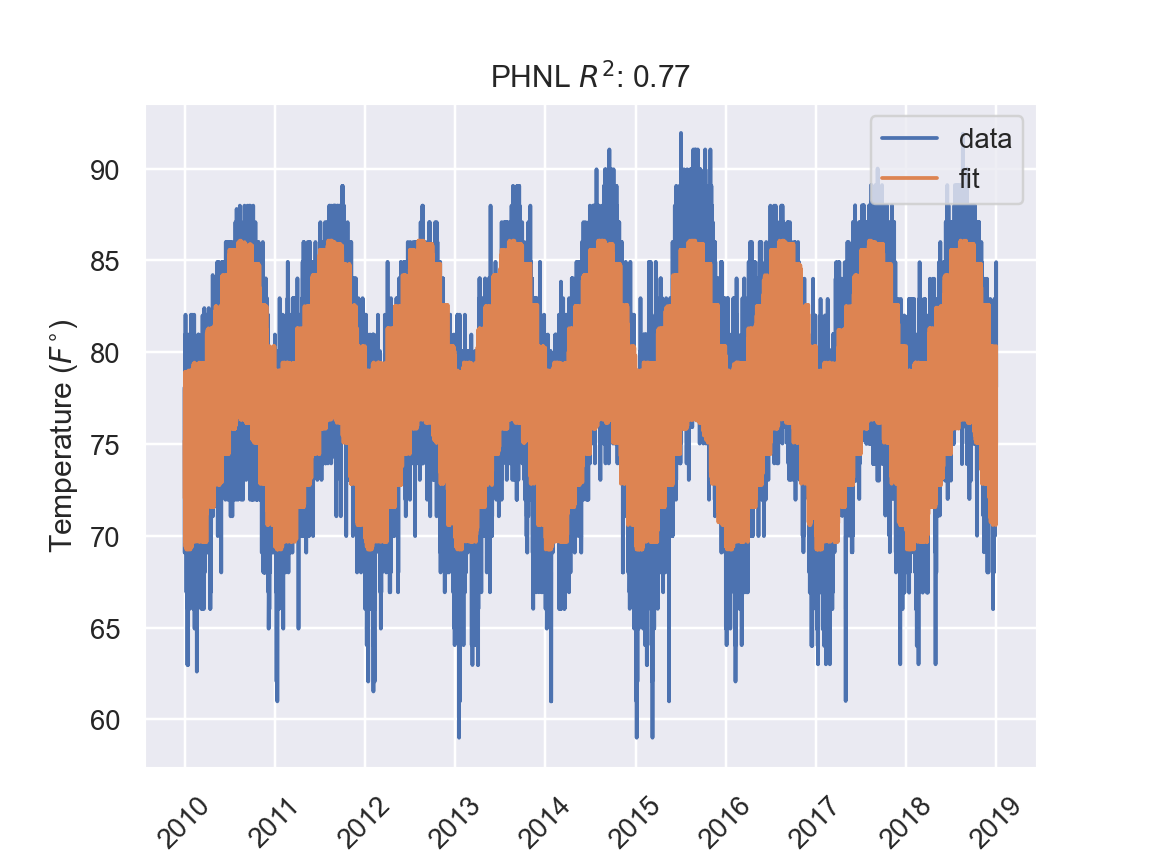

In [19]:
k = 'PHNL'
ordered_valid = valid_data.sort_values(['station','time'],ascending=True).set_index('time')
y = ordered_valid[ordered_valid['station'] == k]['temp'].astype(float)
X = ordered_valid[ordered_valid['station'] == k].index

plt.figure()
plt.plot(X, y, label = 'data') 
plt.plot(X, predictions[k], label = 'fit')
plt.xticks(rotation=45);
plt.ylabel('Temperature ($F^{\circ}$)')

corr_matrix = np.corrcoef(ordered_valid[ordered_valid['station'] == k]['temp'].astype(float).values, predictions[k])
corr = corr_matrix[0,1]
R_sq = corr**2

plt.title('%s $R^2$: %.2f' % (k, R_sq))
plt.legend(loc='upper right')

<IPython.core.display.Javascript object>


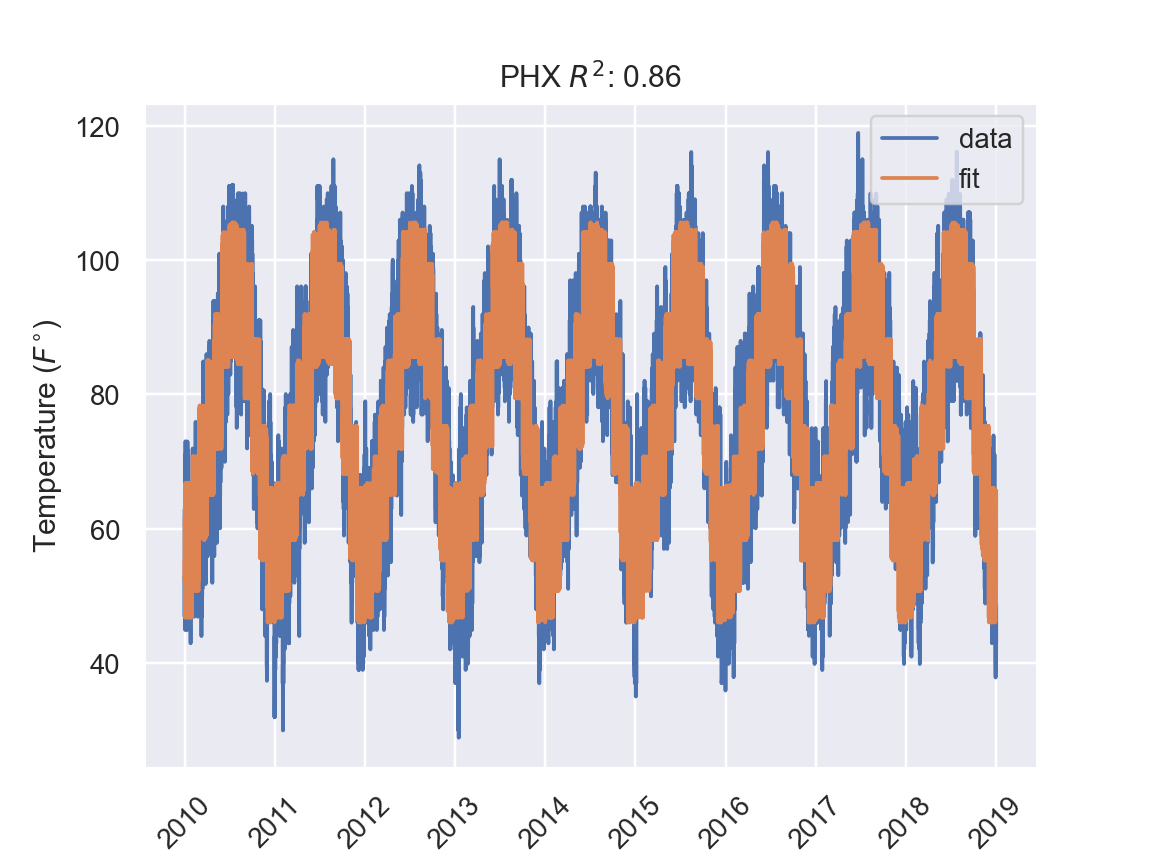

In [20]:
k = 'PHX'
ordered_valid = valid_data.sort_values(['station','time'],ascending=True).set_index('time')
y = ordered_valid[ordered_valid['station'] == k]['temp'].astype(float)
X = ordered_valid[ordered_valid['station'] == k].index

plt.figure()
plt.plot(X, y, label = 'data') 
plt.plot(X, predictions[k], label = 'fit')
plt.xticks(rotation=45);
plt.ylabel('Temperature ($F^{\circ}$)')

corr_matrix = np.corrcoef(ordered_valid[ordered_valid['station'] == k]['temp'].astype(float).values, predictions[k])
corr = corr_matrix[0,1]
R_sq = corr**2

plt.title('%s $R^2$: %.2f' % (k, R_sq))
plt.legend(loc='upper right')

<IPython.core.display.Javascript object>


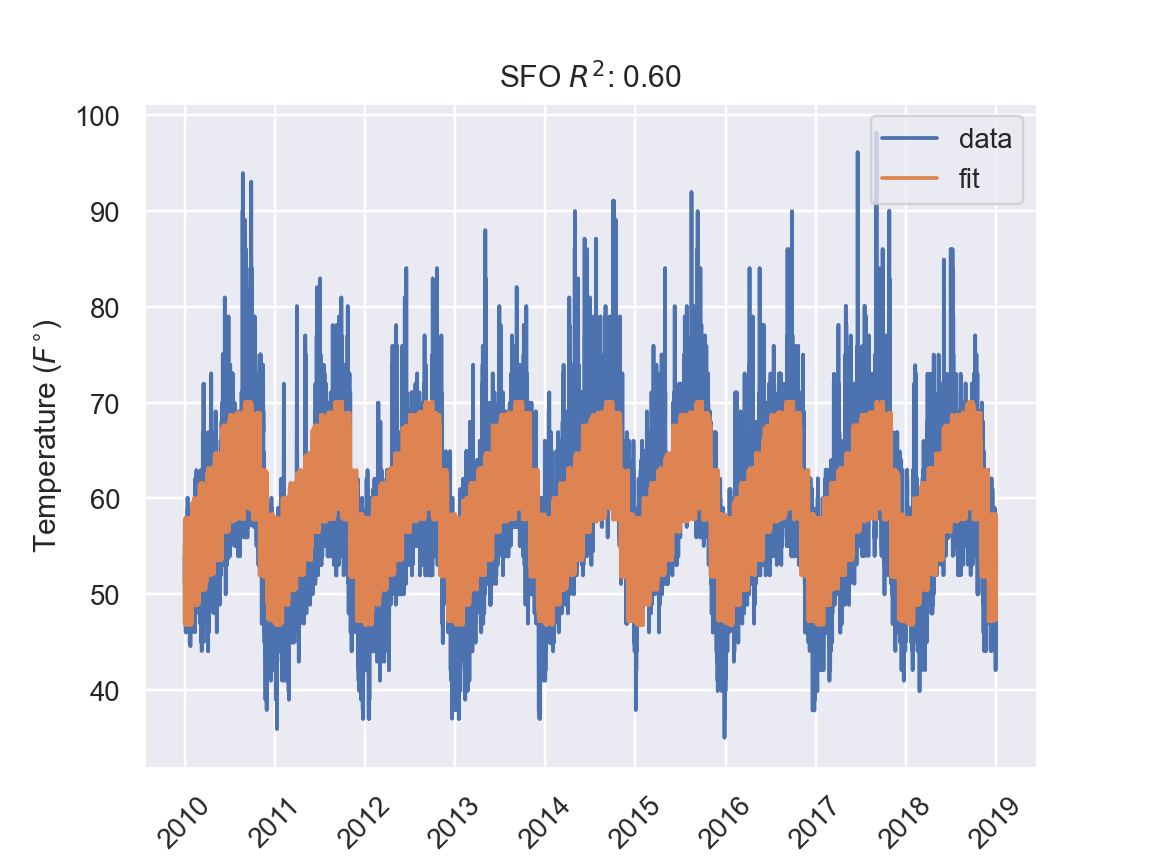

In [21]:
k = 'SFO'
ordered_valid = valid_data.sort_values(['station','time'],ascending=True).set_index('time')
y = ordered_valid[ordered_valid['station'] == k]['temp'].astype(float)
X = ordered_valid[ordered_valid['station'] == k].index

plt.figure()
plt.plot(X, y, label = 'data') 
plt.plot(X, predictions[k], label = 'fit')
plt.xticks(rotation=45);
plt.ylabel('Temperature ($F^{\circ}$)')

corr_matrix = np.corrcoef(ordered_valid[ordered_valid['station'] == k]['temp'].astype(float).values, predictions[k])
corr = corr_matrix[0,1]
R_sq = corr**2

plt.title('%s $R^2$: %.2f' % (k, R_sq))
plt.legend(loc='upper right')

## Fourier model

<IPython.core.display.Javascript object>


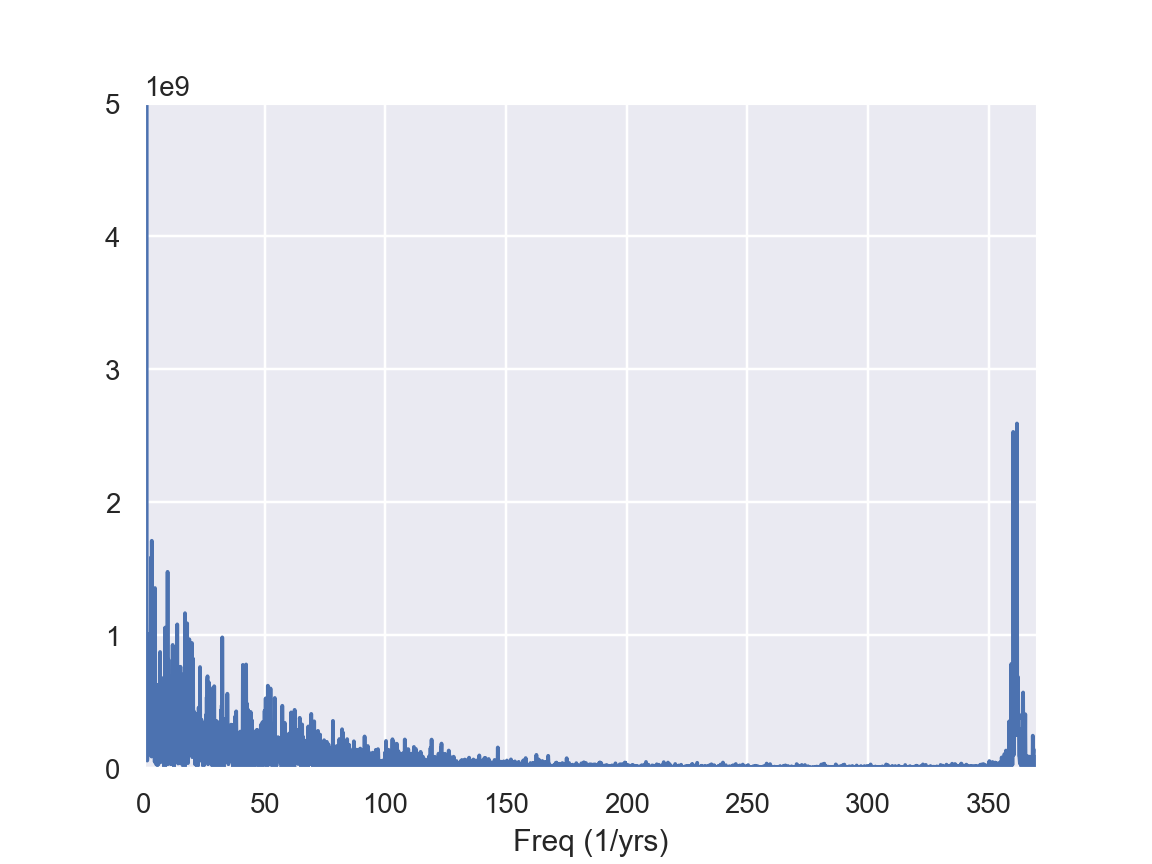

In [22]:
k = 'NYC'
X = df[df['station'] == k].set_index('time').index
y = df[df['station'] == k].set_index('time')['temp'].astype(float)


fft_counts = np.fft.fft(y.values - y.values.mean())
yrs = (y.index[-1] - y.index[0]).days / 365

plt.figure()
plt.plot(np.arange(len(fft_counts)) / yrs, np.abs(fft_counts)**2)
plt.axis([0, 370, 0, 5e9])
plt.xlabel('Freq (1/yrs)');

In [23]:

class FourierComponents(base.BaseEstimator, base.TransformerMixin):
    
    def __init__(self, freq):
        self.freq = freq
    
    def fit(self, X, y=None):
        self.X0 = X[0]
        return self
    
    def transform(self, X):
        dt = (X - self.X0).days * 2 * np.pi * self.freq
        return np.c_[np.sin(dt), np.cos(dt)]


fourier_union = FeatureUnion([('fourier_daily', FourierComponents(1.)),
                              #('fourier_5year', FourierComponents(1./(5*365))),
                              ('fourier_annual', FourierComponents(1/365.))])

In [24]:
def fourier_factory():
    return Pipeline([('indices', IndexSelector()),
                                ('union', fourier_union),
                                ('regressor', LinearRegression())])

In [25]:
%%time
fourier_model = GroupbyEstimator('station', fourier_factory).fit(df, df['temp'])

CPU times: user 710 ms, sys: 100 ms, total: 810 ms
Wall time: 1.33 s


In [26]:
%%time
predictions_fourier = fourier_model.predict(df)

CPU times: user 561 ms, sys: 125 ms, total: 686 ms
Wall time: 537 ms


<IPython.core.display.Javascript object>


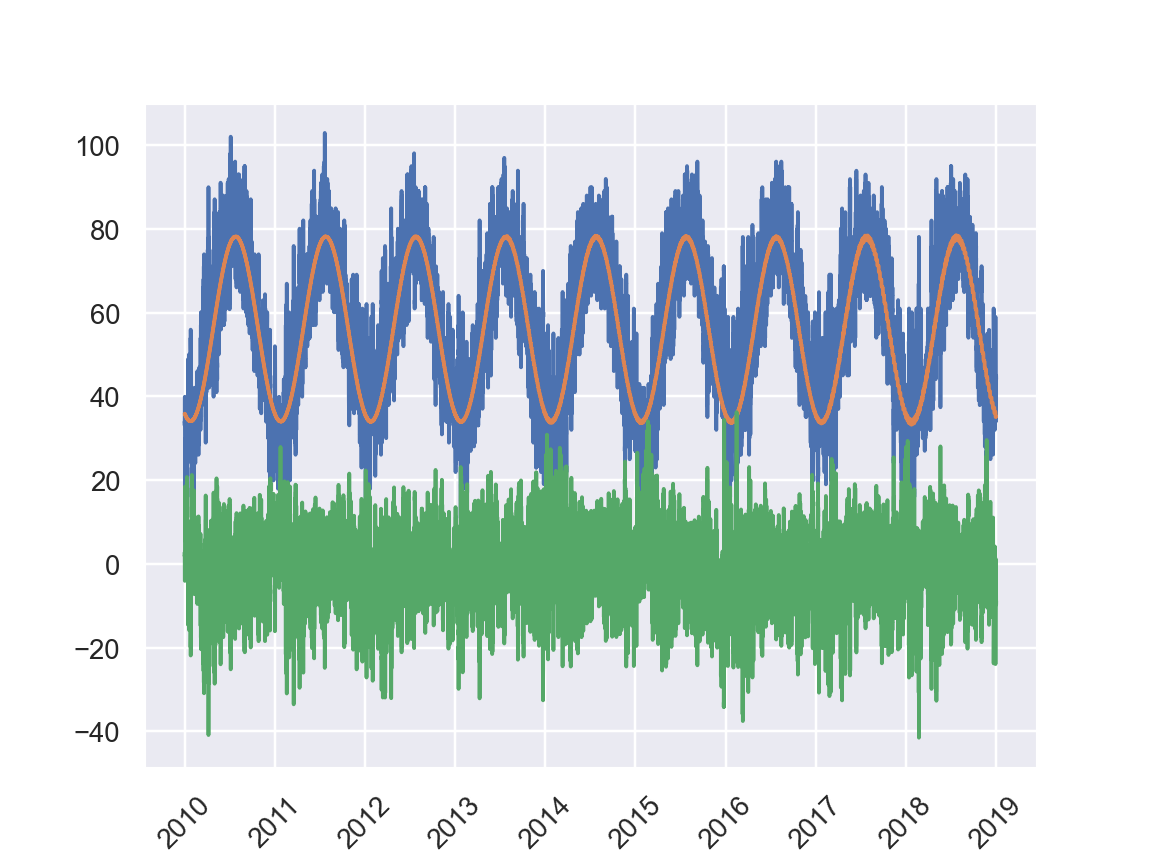

In [27]:
k = 'NYC'
X = df[df['station'] == k].set_index('time').index
y = df[df['station'] == k].set_index('time')['temp'].astype(float)
plt.figure()
plt.plot(X, y, 
         X, predictions_fourier[k],
         X, predictions_fourier[k]-y)
plt.xticks(rotation=45);

In [28]:
for k in predictions_fourier.keys():
    corr_matrix = np.corrcoef(df[df['station'] == k]['temp'].astype(float).values, predictions_fourier[k])
    corr = corr_matrix[0,1]
    R_sq = corr**2

    print('%s R^2: ' % k, R_sq)

PHX R^2:  0.699362066042216
SFO R^2:  0.3076021342975974
PHNL R^2:  0.2764517081800806
MSP R^2:  0.7812882558743223
NYC R^2:  0.7609607449154594
